<a href="https://colab.research.google.com/github/fakhrirobi/ML_Pacmann_5/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd 
import numpy as np 
import joblib

import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go 
import seaborn as sns 
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.serialize import model_to_json, model_from_json
from prophet.diagnostics import performance_metrics
#CONSTANT
DATA_PATH = 'https://github.com/fakhrirobi/ML_Pacmann_5/blob/main/final/20221120_1110_final_data_2018_2022.xlsx?raw=true'

CITIES = ['balikpapan',
 'bandung',
 'batam',
 'jakarta',
 'makassar',
 'medan',
 'palembang',
 'pekanbaru',
 'surabaya',
 'yogyakarta']



## Data Loading 

In [4]:

def load_data() : 
   data = pd.read_excel(DATA_PATH).rename(columns={'Unnamed: 0':'tanggal'})
   data['tanggal'] = pd.to_datetime(data['tanggal'])
   return data
data = load_data()


## Loading data to Prophet

In [5]:
#Since we are predicting price difference by degree one shift 1 , we need to diff in pandas
data_diffed = data.set_index('tanggal')[CITIES].diff(1)

In [6]:
data_diffed.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-09', '2022-11-10', '2022-11-11', '2022-11-12',
               '2022-11-13', '2022-11-14', '2022-11-15', '2022-11-16',
               '2022-11-17', '2022-11-18'],
              dtype='datetime64[ns]', name='tanggal', length=1783, freq=None)

## Exploratory Data Analysis

In [7]:
# Trendline of Price Change Overtime 
fig = make_subplots(rows=10, cols=1)
for idx,col in enumerate(CITIES) : 

  fig.add_trace(go.Scatter(y=data_diffed[f'{col}'], x=data_diffed.index,
                      mode='lines',
                      name=f'{col}'),row=idx+1,col=1)


fig.update_layout(width=1000,height=2000,margin=dict(l=0,r=0,t=0,b=0),paper_bgcolor="#ffffff",
                  title='Cabai Merah Price Change From Different Cities')

In [ ]:
# Add Decomposition Chart 

In [8]:
#define stationarity test 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)



def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [9]:
#Stationarity using AdFuller Test 
for city in CITIES : 
  print(city)
  adf_test(data_diffed[f"{city}"].dropna())
  print("=====================================")

balikpapan
Results of Dickey-Fuller Test:
Test Statistic                 -30.133563
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    909.000000
Critical Value (1%)             -3.437564
Critical Value (5%)             -2.864725
Critical Value (10%)            -2.568466
dtype: float64
bandung
Results of Dickey-Fuller Test:
Test Statistic                -1.378713e+01
p-value                        9.068071e-26
#Lags Used                     3.000000e+00
Number of Observations Used    9.060000e+02
Critical Value (1%)           -3.437588e+00
Critical Value (5%)           -2.864735e+00
Critical Value (10%)          -2.568471e+00
dtype: float64
batam
Results of Dickey-Fuller Test:
Test Statistic                -1.389868e+01
p-value                        5.787941e-26
#Lags Used                     3.000000e+00
Number of Observations Used    9.060000e+02
Critical Value (1%)           -3.437588e+00
Critical Value (5%)           

In [10]:
def pipe_parsing_data(data,city) : 
  data = data[[city]]
  data = data.reset_index()
  data = data.rename(columns={'tanggal':'ds',city:'y'}) #required by prophet 
  return data 

In [11]:
def compute_resid(y_true,y_hat,ds) : 
  #create empty dataframe to contain squared error of requested city 
  error_container = pd.DataFrame()
  error_container['ds'] = ds
  error_container['ytrue'] = y_true
  error_container['residual'] = y_true-y_hat
  error_container['squared_error'] = (y_true-y_hat) ** 2 
  return error_container

In [16]:
## Prophet Modelling 
#create dictionary to store multiple trained model 
cities_dictionary = {}
for city in CITIES :
  #instanciate prophet 
  m = Prophet()

  parsed_df = data_diffed.pipe(pipe_parsing_data,city)
  print(parsed_df.columns)
  # fit the model 
  m.fit(parsed_df)
  forecast_ = m.predict(parsed_df)
  df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
  resid = compute_resid(y_true=parsed_df['y'].values,y_hat=forecast_['yhat'],ds=parsed_df.ds)
  df_val = performance_metrics(df_cv)
  print(f'MSE {city}',df_val['mse'])
  cities_dictionary[city] = {'model':m,'forecast_':forecast_,'resid':resid,'val':df_val}

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/5p4rrpt4.json


Index(['ds', 'y'], dtype='object')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/a5hwaoyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45601', 'data', 'file=/tmp/tmpllp_dzn8/5p4rrpt4.json', 'init=/tmp/tmpllp_dzn8/a5hwaoyd.json', 'output', 'file=/tmp/tmpllp_dzn8/prophet_modelgrdt5xqx/prophet_model-20221126112611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2020-05-27 00:00:00 and 2021-11-18 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/sm5dlohr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/shnqpfa3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64631', 'data', 'file=/tmp/tmpllp_dzn8/sm5dlohr.json', 'init=/tmp/tmpllp_dzn8/shnqpfa3.json', 'output', 'file=/tmp/tmpllp_dzn8/prophet_modelqwihragj/prophet_model-20221126112613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/5w9d_r1y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/4tlec7t2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

MSE balikpapan 0      1.004218e+07
1      1.010703e+07
2      1.011780e+07
3      1.012730e+07
4      1.013337e+07
           ...     
317    1.973528e+07
318    1.883362e+07
319    1.837032e+07
320    1.837318e+07
321    1.837642e+07
Name: mse, Length: 322, dtype: float64
Index(['ds', 'y'], dtype='object')


INFO:prophet:Making 4 forecasts with cutoffs between 2020-05-27 00:00:00 and 2021-11-18 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/yobn2z2d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/9i56ff7u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14824', 'data', 'file=/tmp/tmpllp_dzn8/yobn2z2d.json', 'init=/tmp/tmpllp_dzn8/9i56ff7u.json', 'output', 'file=/tmp/tmpllp_dzn8/prophet_model8tljoo23/prophet_model-20221126112618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/gnpuq6pa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/w2z3g7vk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

MSE bandung 0      1.471353e+07
1      1.387047e+07
2      1.366483e+07
3      1.638431e+07
4      1.545126e+07
           ...     
317    7.595637e+06
318    7.483554e+06
319    8.053787e+06
320    8.038434e+06
321    9.101657e+06
Name: mse, Length: 322, dtype: float64
Index(['ds', 'y'], dtype='object')


11:26:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2020-05-27 00:00:00 and 2021-11-18 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/8maqi42j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/ax30jnaq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32600', 'data', 'file=/tmp/tmpllp_dzn8/8maqi42j.json', 'init=/tmp/tmpllp_dzn8/ax30jnaq.json', 'output', 'file=/tmp/tmpllp_dzn8/prophet_model7bh5f_d0/prophet_model-20221126112623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/u4nxbeof.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/p3dtlv6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

MSE batam 0      7.411780e+06
1      6.304247e+06
2      6.149028e+06
3      6.148086e+06
4      4.995425e+06
           ...     
317    9.013575e+06
318    8.845317e+06
319    8.795081e+06
320    8.771674e+06
321    1.002595e+07
Name: mse, Length: 322, dtype: float64
Index(['ds', 'y'], dtype='object')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/akf2833t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40314', 'data', 'file=/tmp/tmpllp_dzn8/hxl2fkgt.json', 'init=/tmp/tmpllp_dzn8/akf2833t.json', 'output', 'file=/tmp/tmpllp_dzn8/prophet_modelxbntzkz_/prophet_model-20221126112627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2020-05-27 00:00:00 and 2021-11-18 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/hxi4adtb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/j7_gw7wx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76545', 'data', 'file=/tmp/tmpllp_dzn8/hxi4adtb.json', 'init=/tmp/tmpllp_dzn8/j7_gw7wx.json', 'output', 'file=/tmp/tmpllp_dzn8/prophet_modelw46lyf5e/prophet_model-20221126112628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/8hvixbg8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/acl0w3t6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

MSE jakarta 0      8.322123e+06
1      8.532825e+06
2      8.420203e+06
3      1.942276e+07
4      1.885786e+07
           ...     
317    1.718905e+07
318    1.678650e+07
319    1.651752e+07
320    1.624012e+07
321    1.660763e+07
Name: mse, Length: 322, dtype: float64
Index(['ds', 'y'], dtype='object')


INFO:prophet:Making 4 forecasts with cutoffs between 2020-05-27 00:00:00 and 2021-11-18 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/t6nsm4yd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/bopyftst.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=932', 'data', 'file=/tmp/tmpllp_dzn8/t6nsm4yd.json', 'init=/tmp/tmpllp_dzn8/bopyftst.json', 'output', 'file=/tmp/tmpllp_dzn8/prophet_modelo78ezodj/prophet_model-20221126112633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/7j4u2tvq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/tfww_avk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib

MSE makassar 0      1.600677e+07
1      1.591654e+07
2      1.571421e+07
3      1.572073e+07
4      1.567168e+07
           ...     
317    1.889788e+07
318    1.681697e+07
319    1.478551e+07
320    1.478930e+07
321    1.483782e+07
Name: mse, Length: 322, dtype: float64
Index(['ds', 'y'], dtype='object')


INFO:prophet:Making 4 forecasts with cutoffs between 2020-05-27 00:00:00 and 2021-11-18 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/awyp3g8v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/nbvd_bx8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61300', 'data', 'file=/tmp/tmpllp_dzn8/awyp3g8v.json', 'init=/tmp/tmpllp_dzn8/nbvd_bx8.json', 'output', 'file=/tmp/tmpllp_dzn8/prophet_modeluytg8u89/prophet_model-20221126112638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/wf4jkxw1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/jucn_jsg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

MSE medan 0      7.879401e+06
1      7.749188e+06
2      7.759033e+06
3      7.777266e+06
4      7.431583e+06
           ...     
317    9.055989e+06
318    7.909219e+06
319    6.761230e+06
320    6.219792e+06
321    5.932125e+06
Name: mse, Length: 322, dtype: float64
Index(['ds', 'y'], dtype='object')


11:26:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2020-05-27 00:00:00 and 2021-11-18 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/6dqigzur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/4eto9hzw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37036', 'data', 'file=/tmp/tmpllp_dzn8/6dqigzur.json', 'init=/tmp/tmpllp_dzn8/4eto9hzw.json', 'output', 'file=/tmp/tmpllp_dzn8/prophet_modelj01j7znk/prophet_model-20221126112643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/avf1dqnc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/7bt5u1or.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

MSE palembang 0      1.327287e+08
1      1.434455e+08
2      1.557922e+08
3      1.578239e+08
4      1.569208e+08
           ...     
317    1.677194e+07
318    1.657190e+07
319    1.837306e+07
320    1.840839e+07
321    1.936927e+07
Name: mse, Length: 322, dtype: float64
Index(['ds', 'y'], dtype='object')


11:26:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2020-05-27 00:00:00 and 2021-11-18 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/cbkdd3ic.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/4_wdq2fg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9892', 'data', 'file=/tmp/tmpllp_dzn8/cbkdd3ic.json', 'init=/tmp/tmpllp_dzn8/4_wdq2fg.json', 'output', 'file=/tmp/tmpllp_dzn8/prophet_modelhb25r8sn/prophet_model-20221126112649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/y_m0oqz4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/1xfoq9x5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

MSE pekanbaru 0      6.226433e+07
1      6.212587e+07
2      6.216178e+07
3      6.230330e+07
4      6.205621e+07
           ...     
317    9.812721e+06
318    9.760248e+06
319    9.659618e+06
320    8.942933e+06
321    8.411561e+06
Name: mse, Length: 322, dtype: float64
Index(['ds', 'y'], dtype='object')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/ofynenzz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/ka7ybyyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80002', 'data', 'file=/tmp/tmpllp_dzn8/ofynenzz.json', 'init=/tmp/tmpllp_dzn8/ka7ybyyd.json', 'output', 'file=/tmp/tmpllp_dzn8/prophet_model7rsw7xs_/prophet_model-20221126112653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2020-05-27 00:00:00 and 2021-11-18 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/cfn69ue4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/3lz_0uxi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57159', 'data', 'file=/tmp/tmpllp_dzn8/cfn69ue4.json', 'init=/tmp/tmpllp_dzn8/3lz_0uxi.json', 'output', 'file=/tmp/tmpllp_dzn8/prophet_modelempv37y3/prophet_model-20221126112654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/xexeb6ni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/hupb8_ye.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

MSE surabaya 0      3.568334e+06
1      3.449553e+06
2      3.457986e+06
3      7.154554e+06
4      7.044399e+06
           ...     
317    2.680322e+06
318    2.647763e+06
319    2.960785e+06
320    2.960082e+06
321    3.099145e+06
Name: mse, Length: 322, dtype: float64
Index(['ds', 'y'], dtype='object')


INFO:prophet:Making 4 forecasts with cutoffs between 2020-05-27 00:00:00 and 2021-11-18 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/1dvv_8bm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/vvinf6dd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44858', 'data', 'file=/tmp/tmpllp_dzn8/1dvv_8bm.json', 'init=/tmp/tmpllp_dzn8/vvinf6dd.json', 'output', 'file=/tmp/tmpllp_dzn8/prophet_model03n2x_1l/prophet_model-20221126112659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/74ytysee.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllp_dzn8/l9aoenpp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

MSE yogyakarta 0      1.403953e+07
1      1.291505e+07
2      1.290372e+07
3      1.461983e+07
4      1.338881e+07
           ...     
317    1.230554e+07
318    1.231755e+07
319    1.532886e+07
320    1.462751e+07
321    1.509793e+07
Name: mse, Length: 322, dtype: float64


## Plot Each Forecast 

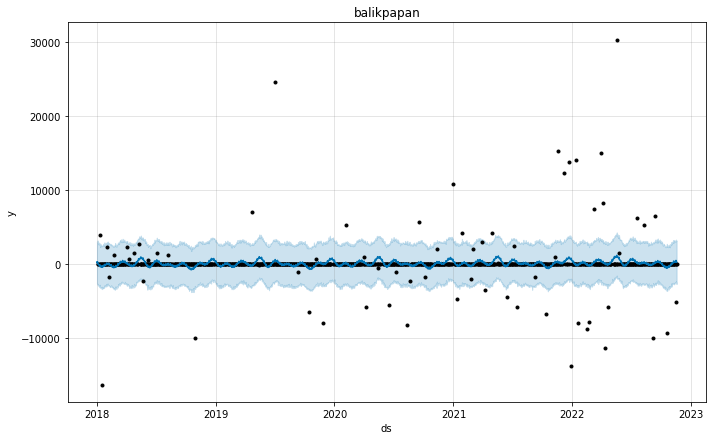

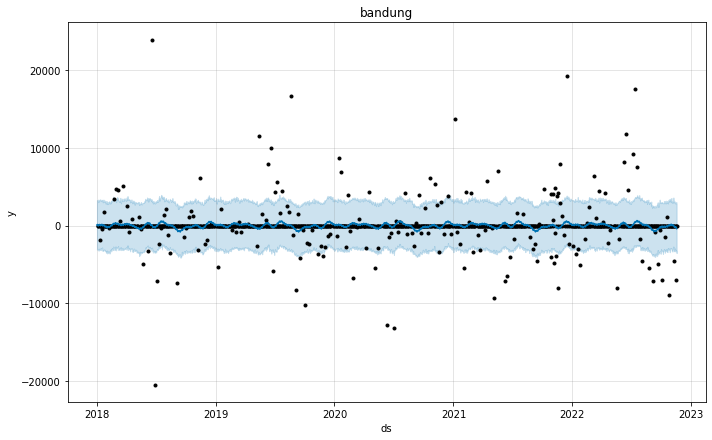

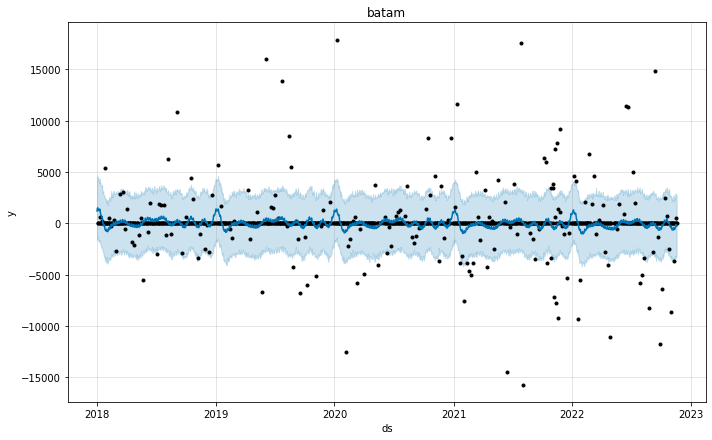

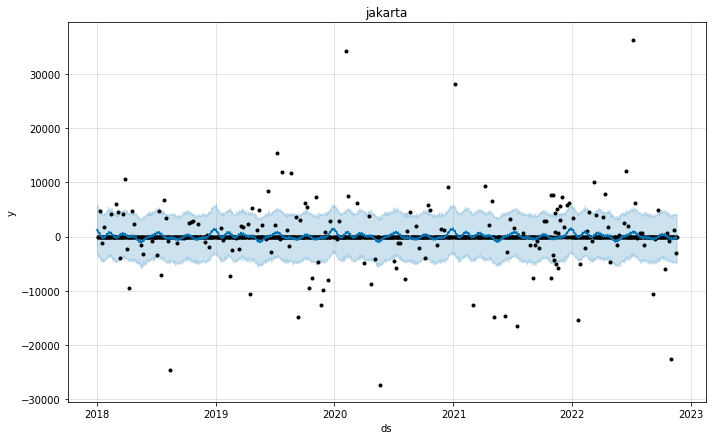

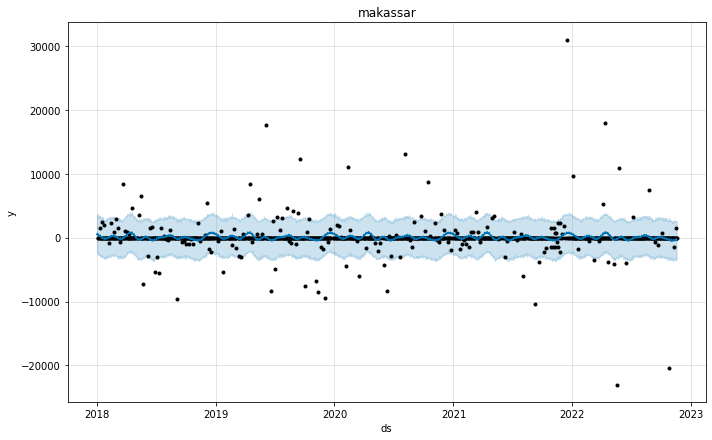

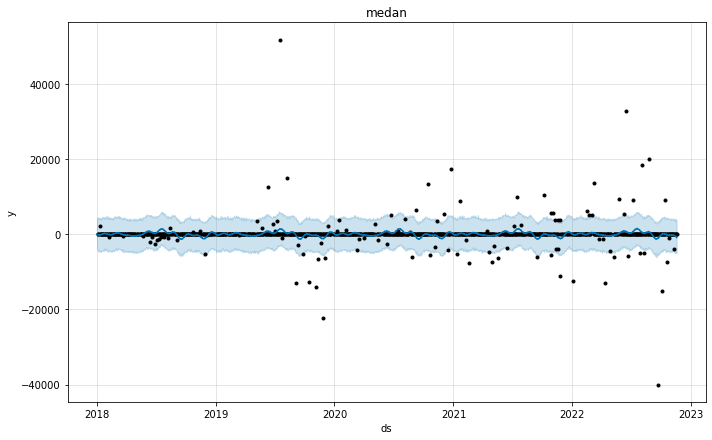

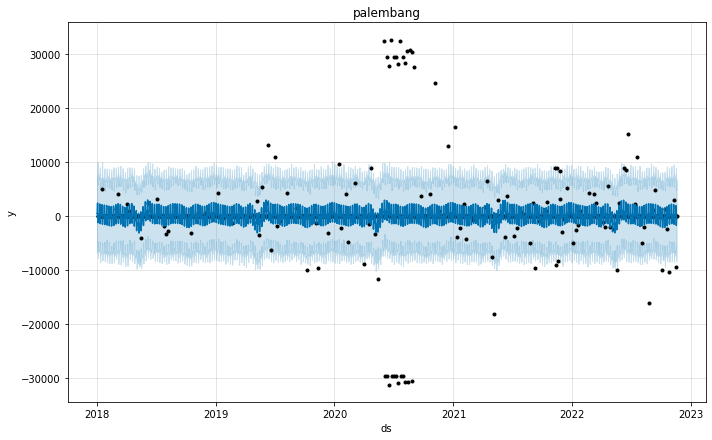

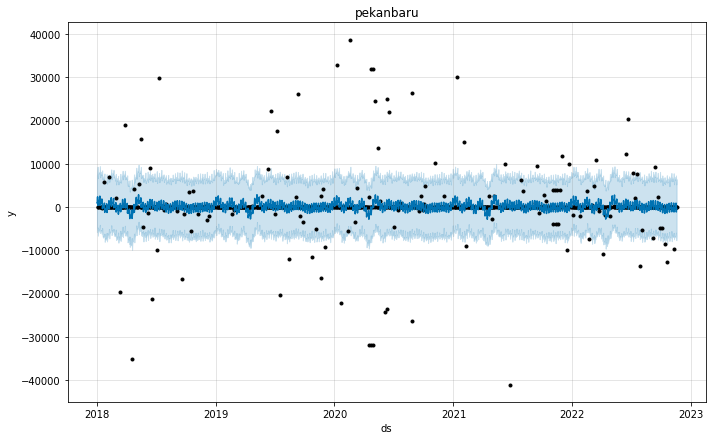

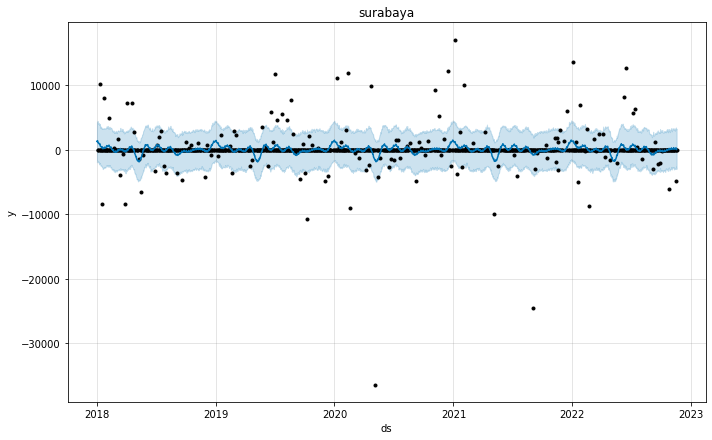

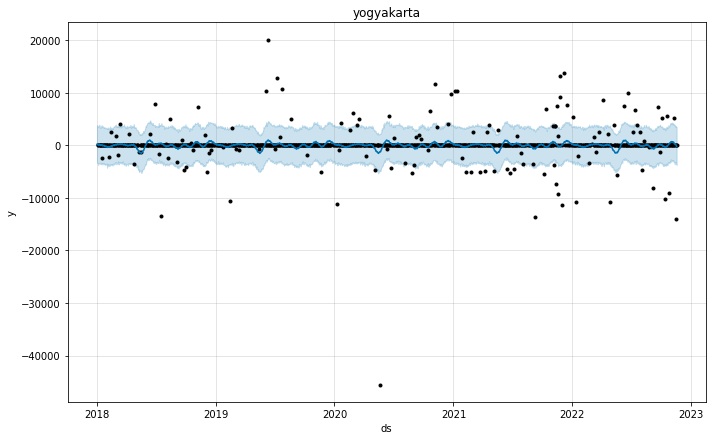

In [20]:
# cities_dictionary[city] = {'model':m,'forecast_'
for city in CITIES :
    m = cities_dictionary[city]['model']
    forecast = cities_dictionary[city]['forecast_']
    fig1 = m.plot(forecast)
    plt.title(city)


In [23]:
for city in CITIES :
  df_val = cities_dictionary[city]['val']
  print(f'{city} MSE',np.mean(df_val['mse']))

balikpapan MSE 8043432.943774825
bandung MSE 6109884.210124718
batam MSE 7824868.946728918
jakarta MSE 12010443.58777485
makassar MSE 7190743.727620217
medan MSE 12133597.576117057
palembang MSE 38795119.52849495
pekanbaru MSE 17813170.86303495
surabaya MSE 6064733.4483387545
yogyakarta MSE 8126061.829242585


## Plot Error Distribution 

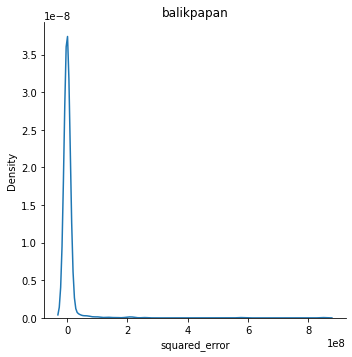

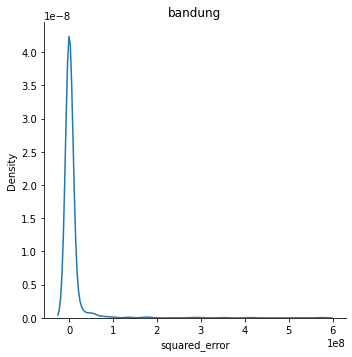

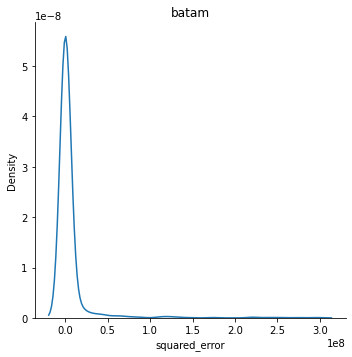

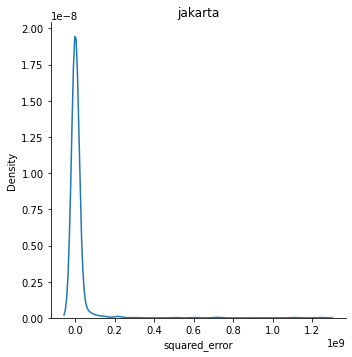

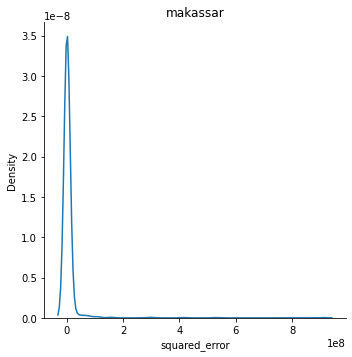

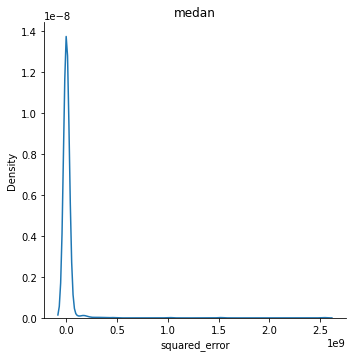

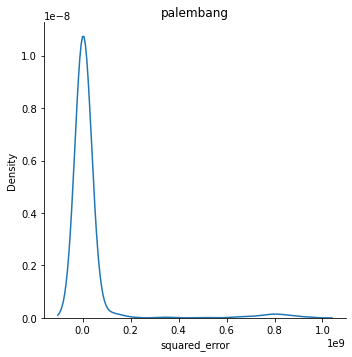

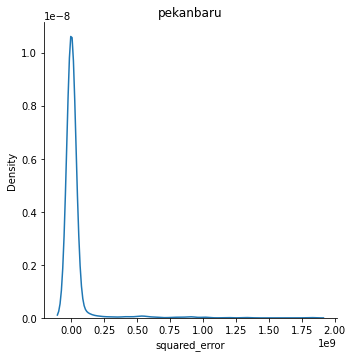

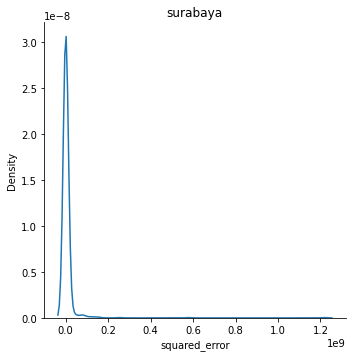

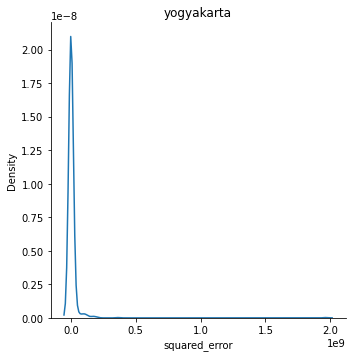

In [25]:
# fig = make_subplots(rows=10, cols=1)
for idx,city in enumerate(CITIES) : 
  
  resid = cities_dictionary.get(city)['resid']
  sns.displot(resid['squared_error'],kind='kde')
  plt.title(city)
  
# fig.show()

## Isolation Forest Modelling Phase

In [27]:
from sklearn.ensemble import IsolationForest

#Loop over city : 
fitted_iso_forest = {}
for idx,city in enumerate(list(cities_dictionary.keys())) : 
  #instanciate isolation forest model 
  resid = cities_dictionary.get(city)['resid'].dropna()
  iso_forest = IsolationForest(random_state=67)
  array_outlier = iso_forest.fit_predict(resid['squared_error'].values.reshape(-1, 1))
  resid['outlier'] = array_outlier
  cities_dictionary[city]['resid']  = resid
  fitted_iso_forest[city] = {'model':iso_forest,'residual':resid}
  joblib.dump(iso_forest,f'{city}_isoforest.joblib')
  #files.download(f'{city}_isoforest.joblib')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [ ]:
#save training file into bundled joblib 
joblib.dump(cities_dictionary,'cities_dict.joblib')
files.download('cities_dict.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
def pipe_concat(data,city) : 
  data  = data.copy()
  data['outlier'] = data['outlier'].map({1:'inlier',-1:'outlier'})
  #adjust outlier , rule -> we only focused on positive price change > 0 thus ou
  filter_adjusted_outlier = (data['ytrue']<=0) & (data['outlier']=="outlier")
  data.loc[filter_adjusted_outlier,'outlier'] = 'inlier'
  print(f'{city} has :{data.outlier.value_counts()}')
  data = data.rename(columns={'squared_error':f'squared_error_{city}','ytrue':f'ytrue_{city}',
                              'outlier' : f'outlier_{city}',
                              'residual':f'residual_{city}'})
  
  return data

In [36]:

container = []
for idx,city in enumerate(list(cities_dictionary.keys())) :
  resid = cities_dictionary.get(city)['resid'].pipe(pipe_concat,city)
  container.append(resid)

balikpapan has :inlier     879
outlier     31
Name: outlier, dtype: int64
bandung has :inlier     844
outlier     66
Name: outlier, dtype: int64
batam has :inlier     856
outlier     54
Name: outlier, dtype: int64
jakarta has :inlier     842
outlier     68
Name: outlier, dtype: int64
makassar has :inlier     857
outlier     53
Name: outlier, dtype: int64
medan has :inlier     873
outlier     37
Name: outlier, dtype: int64
palembang has :inlier     875
outlier     35
Name: outlier, dtype: int64
pekanbaru has :inlier     862
outlier     48
Name: outlier, dtype: int64
surabaya has :inlier     868
outlier     42
Name: outlier, dtype: int64
yogyakarta has :inlier     852
outlier     58
Name: outlier, dtype: int64


In [ ]:
container

[             ds  ytrue_balikpapan  residual_balikpapan  \
 3    2018-01-04               0.0           -22.771243   
 4    2018-01-05               0.0            31.791471   
 8    2018-01-09               0.0           252.664778   
 9    2018-01-10            4000.0          4079.482757   
 10   2018-01-11               0.0           338.695314   
 ...         ...               ...                  ...   
 1775 2022-11-11               0.0          -256.811386   
 1779 2022-11-15               0.0          -288.768694   
 1780 2022-11-16           -5050.0         -5551.713373   
 1781 2022-11-17               0.0          -272.129294   
 1782 2022-11-18               0.0          -268.861541   
 
       squared_error_balikpapan outlier_balikpapan  
 3                 5.185295e+02             inlier  
 4                 1.010698e+03             inlier  
 8                 6.383949e+04             inlier  
 9                 1.664218e+07            outlier  
 10                1.1471

## Sanity Check

In [ ]:
filter_balikpapan_outlier = combined_outlier['outlier_balikpapan']=='outlier'

In [ ]:
combined_outlier.loc[filter_balikpapan_outlier,['ytrue_balikpapan','squared_error_balikpapan','ds']]

,ytrue_balikpapan,squared_error_balikpapan,ds
9,4000.0,16642179.56776,2018-01-10
16,-16250.0,257798799.234949,2018-01-17
30,2350.0,4787624.708346,2018-01-31
37,-1800.0,3766907.373405,2018-02-07
51,1300.0,2380081.485701,2018-02-21
...,...,...,...
1682,5300.0,24760165.844513,2022-08-10
1710,-10000.0,103322912.727766,2022-09-07
1717,6500.0,37544196.733285,2022-09-14
1752,-9250.0,79838513.914791,2022-10-19


In [ ]:
range_squared = combined_outlier.loc[filter_balikpapan_outlier,['ytrue_balikpapan','squared_error_balikpapan','ds']]['ytrue_balikpapan']

In [ ]:
range_squared_inlier = combined_outlier.loc[filter_balikpapan_inl,['ytrue_balikpapan','squared_error_balikpapan','ds']]['ytrue_balikpapan']

In [ ]:
px.histogram(range_squared)

In [ ]:
combined_outlier.loc[filter_balikpapan_inl,['ytrue_balikpapan','squared_error_balikpapan','ds']]['ytrue_balikpapan']

In [ ]:
range_squared_inlier

In [ ]:
combined_outlier = pd.concat(container,axis=1)
combined_outlier=combined_outlier.T.drop_duplicates().T

In [ ]:
combined_outlier.isnull().sum()

ds                          0
ytrue_balikpapan            0
residual_balikpapan         0
squared_error_balikpapan    0
outlier                     0
ytrue_bandung               0
residual_bandung            0
squared_error_bandung       0
outlier                     0
ytrue_batam                 0
residual_batam              0
squared_error_batam         0
outlier                     0
ytrue_jakarta               0
residual_jakarta            0
squared_error_jakarta       0
outlier                     0
ytrue_makassar              0
residual_makassar           0
squared_error_makassar      0
outlier                     0
ytrue_medan                 0
residual_medan              0
squared_error_medan         0
outlier                     0
ytrue_palembang             0
residual_palembang          0
squared_error_palembang     0
outlier                     0
ytrue_pekanbaru             0
residual_pekanbaru          0
squared_error_pekanbaru     0
outlier                     0
ytrue_sura

## 

In [ ]:
combined_outlier

,ds,ytrue_balikpapan,residual_balikpapan,squared_error_balikpapan,outlier,ytrue_bandung,residual_bandung,squared_error_bandung,outlier,ytrue_batam,...,squared_error_pekanbaru,outlier,ytrue_surabaya,residual_surabaya,squared_error_surabaya,outlier,ytrue_yogyakarta,residual_yogyakarta,squared_error_yogyakarta,outlier
3,2018-01-04,0.0,-22.771243,518.529525,inlier,0.0,-53.666434,2880.086086,inlier,0.0,...,155911.534267,inlier,0.0,-1164.79727,1356752.68088,inlier,0.0,-109.653549,12023.900712,inlier
4,2018-01-05,0.0,31.791471,1010.697619,inlier,0.0,36.012464,1296.897553,inlier,0.0,...,1557242.546005,inlier,0.0,-1082.232072,1171226.258635,inlier,0.0,-10.248727,105.036397,inlier
8,2018-01-09,0.0,252.664778,63839.489999,inlier,0.0,-156.646789,24538.216488,inlier,0.0,...,2037872.396939,inlier,0.0,-871.677319,759821.348963,inlier,0.0,-157.125211,24688.331822,inlier
9,2018-01-10,4000.0,4079.482757,16642179.56776,outlier,-1900.0,-2045.10183,4182441.494989,outlier,600.0,...,892136.68581,inlier,10200.0,9251.812892,85596041.782324,outlier,0.0,-149.136906,22241.81665,inlier
10,2018-01-11,0.0,338.695314,114714.515625,inlier,0.0,-76.488623,5850.509429,inlier,0.0,...,184954.012194,inlier,0.0,-659.777895,435306.871306,inlier,0.0,-41.0095,1681.779086,inlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775,2022-11-11,0.0,-256.811386,65952.088182,inlier,0.0,182.175206,33187.805624,inlier,0.0,...,124192.554947,inlier,0.0,-113.259299,12827.668737,inlier,0.0,-281.961298,79502.173651,inlier
1779,2022-11-15,0.0,-288.768694,83387.35845,inlier,0.0,128.973537,16634.173324,inlier,0.0,...,55915.684918,inlier,0.0,-180.954211,32744.42656,inlier,0.0,-190.140257,36153.317245,inlier
1780,2022-11-16,-5050.0,-5551.713373,30821521.37417,outlier,-7000.0,-6827.17393,46610303.866422,outlier,500.0,...,852764.435291,inlier,-4750.0,-5080.515643,25811639.201963,outlier,-14100.0,-14219.089536,202182507.243611,outlier
1781,2022-11-17,0.0,-272.129294,74054.352701,inlier,0.0,269.845439,72816.561196,inlier,0.0,...,1264824.715883,inlier,0.0,-112.588856,12676.250505,inlier,0.0,48.73994,2375.581711,inlier


In [ ]:
combined_outlier.columns

Index(['ds', 'ytrue_balikpapan', 'residual_balikpapan',
       'squared_error_balikpapan', 'outlier_balikpapan', 'ytrue_bandung',
       'residual_bandung', 'squared_error_bandung', 'ytrue_batam',
       'residual_batam', 'squared_error_batam', 'ytrue_jakarta',
       'residual_jakarta', 'squared_error_jakarta', 'ytrue_makassar',
       'residual_makassar', 'squared_error_makassar', 'ytrue_medan',
       'residual_medan', 'squared_error_medan', 'ytrue_palembang',
       'residual_palembang', 'squared_error_palembang', 'ytrue_pekanbaru',
       'residual_pekanbaru', 'squared_error_pekanbaru', 'ytrue_surabaya',
       'residual_surabaya', 'squared_error_surabaya', 'ytrue_yogyakarta',
       'residual_yogyakarta', 'squared_error_yogyakarta'],
      dtype='object')

In [ ]:
combined_outlier

,ds,ytrue_balikpapan,residual_balikpapan,squared_error_balikpapan,outlier,ytrue_bandung,residual_bandung,squared_error_bandung,outlier,ytrue_batam,...,squared_error_pekanbaru,outlier,ytrue_surabaya,residual_surabaya,squared_error_surabaya,outlier,ytrue_yogyakarta,residual_yogyakarta,squared_error_yogyakarta,outlier
3,2018-01-04,0.0,-22.771243,518.529525,inlier,0.0,-53.666434,2880.086086,inlier,0.0,...,155911.534267,inlier,0.0,-1164.79727,1356752.68088,inlier,0.0,-109.653549,12023.900712,inlier
4,2018-01-05,0.0,31.791471,1010.697619,inlier,0.0,36.012464,1296.897553,inlier,0.0,...,1557242.546005,inlier,0.0,-1082.232072,1171226.258635,inlier,0.0,-10.248727,105.036397,inlier
8,2018-01-09,0.0,252.664778,63839.489999,inlier,0.0,-156.646789,24538.216488,inlier,0.0,...,2037872.396939,inlier,0.0,-871.677319,759821.348963,inlier,0.0,-157.125211,24688.331822,inlier
9,2018-01-10,4000.0,4079.482757,16642179.56776,outlier,-1900.0,-2045.10183,4182441.494989,outlier,600.0,...,892136.68581,inlier,10200.0,9251.812892,85596041.782324,outlier,0.0,-149.136906,22241.81665,inlier
10,2018-01-11,0.0,338.695314,114714.515625,inlier,0.0,-76.488623,5850.509429,inlier,0.0,...,184954.012194,inlier,0.0,-659.777895,435306.871306,inlier,0.0,-41.0095,1681.779086,inlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775,2022-11-11,0.0,-256.811386,65952.088182,inlier,0.0,182.175206,33187.805624,inlier,0.0,...,124192.554947,inlier,0.0,-113.259299,12827.668737,inlier,0.0,-281.961298,79502.173651,inlier
1779,2022-11-15,0.0,-288.768694,83387.35845,inlier,0.0,128.973537,16634.173324,inlier,0.0,...,55915.684918,inlier,0.0,-180.954211,32744.42656,inlier,0.0,-190.140257,36153.317245,inlier
1780,2022-11-16,-5050.0,-5551.713373,30821521.37417,outlier,-7000.0,-6827.17393,46610303.866422,outlier,500.0,...,852764.435291,inlier,-4750.0,-5080.515643,25811639.201963,outlier,-14100.0,-14219.089536,202182507.243611,outlier
1781,2022-11-17,0.0,-272.129294,74054.352701,inlier,0.0,269.845439,72816.561196,inlier,0.0,...,1264824.715883,inlier,0.0,-112.588856,12676.250505,inlier,0.0,48.73994,2375.581711,inlier


## Outlier Annotation

In [ ]:
combined_outliers = pd.concat(container,axis=1)
combined_outliers=combined_outliers.T.drop_duplicates().T

In [ ]:
combined_outliers.isnull().sum()

ds                          0
ytrue_balikpapan            0
residual_balikpapan         0
squared_error_balikpapan    0
outlier_balikpapan          0
ds                          0
ytrue_bandung               0
residual_bandung            0
squared_error_bandung       0
outlier_bandung             0
ds                          0
ytrue_batam                 0
residual_batam              0
squared_error_batam         0
outlier_batam               0
ds                          0
ytrue_jakarta               0
residual_jakarta            0
squared_error_jakarta       0
outlier_jakarta             0
ds                          0
ytrue_makassar              0
residual_makassar           0
squared_error_makassar      0
outlier_makassar            0
ds                          0
ytrue_medan                 0
residual_medan              0
squared_error_medan         0
outlier_medan               0
ds                          0
ytrue_palembang             0
residual_palembang          0
squared_er

In [ ]:
def generate_outlier_plot(city) : 
    figure_outlier = go.Figure()
    parsed_data = data_diffed[[city]].reset_index()
    trace1 = go.Scatter(y=parsed_data[f'{city}'], x=parsed_data.tanggal,
                        mode='lines',
                        name=f'{city}')
    figure_outlier.add_trace(trace=trace1)
    # #get anotated result
    filter_date = combined_outliers[f'outlier_{city}']=='outlier'
    list_date=combined_outliers.loc[filter_date,'ds'].to_list()
    parsed_outlier_filter = parsed_data['tanggal'].isin(list_date)
    parsed_data_outlier_df = parsed_data.loc[parsed_outlier_filter]
    trace2 = go.Scatter(y=parsed_data_outlier_df[f'{city}'], x=parsed_data_outlier_df.tanggal,
                        mode='markers',
                        name=f'{city}')
    figure_outlier.add_trace(trace=trace2)
    figure_outlier.update_layout(width=2000,height=500,margin=dict(l=0,r=0,b=0,t=0),xaxis_rangeslider_visible=True)
    figure_outlier.show()

In [ ]:
generate_outlier_plot('medan')

In [ ]:
generate_outlier_plot('bandung')